In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torchvision import datasets, transforms

In [2]:
transform = transforms.ToTensor()

In [3]:
train_data = datasets.CIFAR10(root='/content/drive/MyDrive/Colab Notebooks/Dataset', train=True, download = True, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/drive/MyDrive/Colab Notebooks/Dataset/cifar-10-python.tar.gz to /content/drive/MyDrive/Colab Notebooks/Dataset


In [4]:
test_data = datasets.CIFAR10(root='/content/drive/MyDrive/Colab Notebooks/Dataset', train=False, download = True, transform=transform)

Files already downloaded and verified


In [5]:
test_data


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/Colab Notebooks/Dataset
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: /content/drive/MyDrive/Colab Notebooks/Dataset
    Split: Train
    StandardTransform
Transform: ToTensor()

In [7]:
torch.manual_seed(101)
train_loader = DataLoader(train_data, batch_size = 10, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 10, shuffle=False)

In [8]:
class_names = ['plane' , 'car' , 'bird' , 'cat', 'deer', 'dog' , 'frog', 'horse','ship' , 'truck']


In [9]:
for images, labels in train_loader:
  break

In [10]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

In [11]:
images[0].shape

torch.Size([3, 32, 32])

car  dog  ship  car  frog  car  frog  cat  horse  truck  


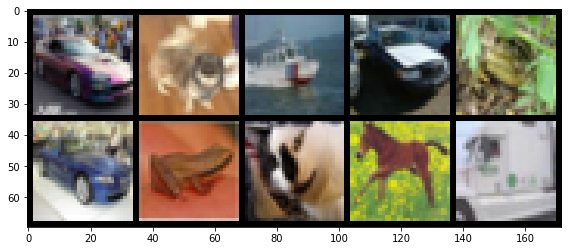

In [12]:
im = make_grid(images , nrow=5)
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1,2,0)))

lbl = ""
for x in labels:
  lbl += class_names[x] + "  "
print(lbl)

In [13]:
class ConvNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    #inp-chnl -> 3
    #out-chnl == Filters -> 6 (number of filters 6d)
    #kernel = 5 (each filter is of 3x3 kernel)
    #stride = 1
    self.conv1 = nn.Conv2d(3,6,3,1)
    #inp-chnl -> 6 filters of prev layer 
    #out-chnl -> 16 filters (randomly picked)
    #kernel -> 3x3 image kernel
    #stride = 1
    self.conv2 = nn.Conv2d(6,16,3,1)
    self.fc1 = nn.Linear(6*6*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10)
  
  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
    X = X.view(-1, 6*6*16)
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X, dim=1)
    

In [14]:
torch.manual_seed(101)
model = ConvNetwork()
model

ConvNetwork(
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [15]:
for param in model.parameters():
  print(param.numel())

162
6
864
16
69120
120
10080
84
840
10


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed            

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.78730226  accuracy:  24.450%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 2.28565931  accuracy:  30.450%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.45820069  accuracy:  34.273%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.80153239  accuracy:  37.062%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 0.99681675  accuracy:  39.514%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.37326109  accuracy:  50.280%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.30945385  accuracy:  51.185%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.40927875  accuracy:  51.997%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.17306864  accuracy:  52.443%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 0.91626465  accuracy:  52.726%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.12189531  accuracy:  55.690%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.86757290  accuracy:  56.250%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.05930436  accuracy:  56.467%
epoch:  2  b